# Fraudulent Account Detection

The file users.csv contains data on a subset of fictional banking users. The abbreviation 'KYC' stands for 'Know Your Customer' - a process of identifying and verifying the client's identity when opening an account and periodically over time. The variable IS_FRAUDSTER from this dataset is your target variable. The file transactions.csv contains details of fictional transactions of these users.

Project and data procured from collected from [StrataScratch](https://platform.stratascratch.com/).

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, precision_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics, preprocessing
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime

#date time
now = datetime.now()
print('Analysis on', now.strftime('%Y-%m-%d'), 'at', now.strftime('%H:%M'))

Analysis on 2024-04-09 at 10:39


## Data Exploration

As shown through our initial exploration, below, we are starting with two dataframes derived from provided CSV files. I'm also including a third dataframe which provides details on currencies vs. country of origin. This was generated from the [UPS Country/Territory and Currency Codes document](https://www.ups.com/worldshiphelp/WSA/ENG/AppHelp/mergedProjects/CORE/Codes/Country_Territory_and_Currency_Codes.htm). By doing so, we will have three starting dataframes:

| Dataframe | Source | Description |
|-|-|-|
| transactions | transactions.csv | Each row represents an individual transation with various details, including user, currency type, amount, and other relevant information. |
| users | users.csv | Each row represents a single user with various details related to the user's account. included is the 'is_fraudster' identifier, which is our target. |
| ccy | ups_currencies.csv | Each row represents a single currency type used in different countries |

The goal of this section and the next is to understand the relevant features in each dataframe, and figure out a way to combine the relevant details into a singular resource for analysis. 

In [2]:
# load data
transactions = pd.read_csv('data/FRAUD-transactions.csv')
users = pd.read_csv('data/FRAUD-users.csv')
ccy = pd.read_csv('data/FRAUD-ups_currencies.csv')

# set names for dataframes for reference
transactions.name = 'Transactions'
users.name = 'Users'
ccy.name = 'CCY'

# create a list of dataframes for iteration
dataframes = [transactions, users, ccy]

In [3]:
# get info for each dataframe
for df in dataframes: print(df.info(),'\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688651 entries, 0 to 688650
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CURRENCY           688651 non-null  object 
 1   AMOUNT             688651 non-null  int64  
 2   STATE              688651 non-null  object 
 3   CREATED_DATE       688651 non-null  object 
 4   MERCHANT_CATEGORY  223065 non-null  object 
 5   MERCHANT_COUNTRY   483055 non-null  object 
 6   ENTRY_METHOD       688651 non-null  object 
 7   USER_ID            688651 non-null  object 
 8   TYPE               688651 non-null  object 
 9   SOURCE             688651 non-null  object 
 10  ID                 688651 non-null  object 
 11  AMOUNT_USD         635328 non-null  float64
dtypes: float64(1), int64(1), object(10)
memory usage: 63.0+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 11 columns):
 #   Column              

In [4]:
# function to get unique and null values for each column in a dataframe
def matrix(dataframe):
    temp = [[dataframe[column].nunique() for column in dataframe.columns],
            [dataframe[column].isnull().sum() for column in dataframe.columns]]
    print(dataframe.name,'has',len(dataframe),'total values; column details:\n')
    print(pd.DataFrame(temp, columns=dataframe.columns, index=['Unique Values', 'Null Values']).transpose())

# iterate through dataframes to get unique and null values for each column
for df in dataframes: print(matrix(df),'\n--------------------------\n') 

Transactions has 688651 total values; column details:

                   Unique Values  Null Values
CURRENCY                      29            0
AMOUNT                     32257            0
STATE                          7            0
CREATED_DATE              688640            0
MERCHANT_CATEGORY            115       465586
MERCHANT_COUNTRY             344       205596
ENTRY_METHOD                   6            0
USER_ID                     8021            0
TYPE                           5            0
SOURCE                        11            0
ID                        688651            0
AMOUNT_USD                 37402        53323
None 
--------------------------

Users has 9944 total values; column details:

                         Unique Values  Null Values
ID                                9944            0
HAS_EMAIL                            2            0
PHONE_COUNTRY                       83            0
IS_FRAUDSTER                         2            0
TERMS_V

In [5]:
transactions.head(3).transpose()

,0,1,2
CURRENCY,GBP,PLN,GBP
AMOUNT,4420,1500,191
STATE,COMPLETED,COMPLETED,COMPLETED
CREATED_DATE,2017-12-10 16:38:55.577,2017-12-10 16:37:24.792,2017-12-10 16:37:16.234
MERCHANT_CATEGORY,NaN,point_of_interest,airport
MERCHANT_COUNTRY,NLD,POL,PRT
ENTRY_METHOD,chip,manu,chip
USER_ID,3ff52b92-d416-4e22-8cad-018f500d4bbc,76cbaad3-4721-4a3b-92b9-3eb9e9319565,7bcaa34e-b889-4582-9c29-0b3bab34fb8c
TYPE,ATM,CARD_PAYMENT,CARD_PAYMENT
SOURCE,GAIA,GAIA,GAIA


In [6]:
users.head(3).transpose()

,0,1,2
ID,1872820f-e3ac-4c02-bdc7-727897b60043,545ff94d-66f8-4bea-b398-84425fb2301e,10376f1a-a28a-4885-8daa-c8ca496026bb
HAS_EMAIL,1,1,1
PHONE_COUNTRY,GB||JE||IM||GG,GB||JE||IM||GG,ES
IS_FRAUDSTER,False,False,False
TERMS_VERSION,2018-05-25,2018-01-01,2018-09-20
CREATED_DATE,2017-08-06 07:33:33.341000,2017-03-07 10:18:59.427000,2018-05-31 04:41:24.672000
STATE,ACTIVE,ACTIVE,ACTIVE
COUNTRY,GB,GB,ES
BIRTH_YEAR,1971,1982,1973
KYC,PASSED,PASSED,PASSED


In [7]:
ccy.head(3).transpose()

,0,1,2
COUNTRY,Afghanistan,Aland Islands,Albania
UPS_Code,AF,AX,AL
IATA_Code,AF,AX,AL
CCY,USD,EUR,EUR


Before getting too much further, I'm going to check the correlation between the users's state, number of failed sign-in attempts, and KYC status as compared to if the user is a fraudster. The goal is to identify if there is a 1:1 ratio, in which case the variable would be meaningless. 

As shown below, there is a 1:1 correlation for if the account is locked, so we won't use that variable. However, the other two (KYC and failed sign in attempts) are still potential options. 

In [8]:
# check for connection between STATE and IS_FRAUDSTER
fraudsters = users[users['IS_FRAUDSTER'] == True]
not_fraudsters = users[users['IS_FRAUDSTER'] == False]
print('Account states for fraud accounts:',fraudsters['STATE'].unique(), 
      '\nAccount states for non-fraud accounts:', not_fraudsters['STATE'].unique(),
      '\n\nKYC for fraud accounts:',fraudsters['KYC'].unique(), 
      '\nKYC for non-fraud accounts:', not_fraudsters['KYC'].unique(),
      '\n\nFailed Sign In for fraud accounts:',fraudsters['FAILED_SIGN_IN_ATTEMPTS'].unique(), 
      '\nFailed Sign In for non-fraud accounts:', not_fraudsters['FAILED_SIGN_IN_ATTEMPTS'].unique())

Account states for fraud accounts: ['LOCKED'] 
Account states for non-fraud accounts: ['ACTIVE'] 

KYC for fraud accounts: ['NONE' 'PASSED' 'PENDING' 'FAILED'] 
KYC for non-fraud accounts: ['PASSED' 'NONE' 'FAILED' 'PENDING'] 

Failed Sign In for fraud accounts: [0 1 2] 
Failed Sign In for non-fraud accounts: [0 1 3 2 6]


From here we'll begin feature engineering using the three remaining dataframes, and continue unifying all relevant data into a single dataframe. 

## Feature Engineering
For the analysis, I'm proposing the following initial features as potential predictors:
| Column| Type | Description| 
|------------- |------------- |-------------|
| IS_FRAUDSTER	| bool	| user IDed as fraudster	| 
| HAS_EMAIL	| bool	| user has registered email	| 
| FAILED_SIGN_IN_ATTEMPTS	| cont	| count of failed sign in attempts	|
| KYC_[STATUS]	| dummy/bool	| user's stage in identification verification	|
| PHONE_COUNTRY_MATCH	| bool	| user's listed country matches their phone's country code	|
| PHONE_MULTIPLE_COUNTRIES	| bool	| user has phone numbers in multiple countries	|
| RECENT_TERMS	| bool	| user has accepted the most recent TOC|
| CREATED_TO_FIRST	| cont	| minutes between account creation to first transaction|
| TOTAL_TRANSACTION_COUNT	| int	| count of user's total transactions	|
| TOTAL_TRANSACTION_SUM	| cont	| sum of user's total transaction amounts	|
| MEDIAN_TRANSACTION_AMOUNT	| cont	| median transaction amount	|
| AVG_DAILY_TRANSACTION_COUNT	| cont	| average transactions made per day by user	|
| INTL_TRANSACTION_PCT	| cont	| percent of user's transactions that don't match their listed country's currency	|
| TYPE_[TYPE]	| cont	| percent of transactions made of each transaction type	|
| METHOD_[METHOD]	| cont	| percent of transactions attributed to different entry methods	|

Note: Each sample accounts for a single user. Additionally, all these features will not be used in the final analysis. We are simply generating them as a starting point to identify the most relevant features. 

This first section takes care of the low-hanging fruit:
* Updating data types and renaming columns as needed
* Creating the analysis dataframe with features that are already ready for use
* Generating new features according to the following:
    * If the user's country and the country code for their phone match
    * If the user has more than one phone country listed
    * If the user has accepted the most recent terms of service

In [9]:
# update date types to datetime for calculating
users['TERMS_VERSION'] = pd.to_datetime(users['TERMS_VERSION'])
users['CREATED_DATE'] = pd.to_datetime(users['CREATED_DATE'])
transactions['CREATED_DATE'] = pd.to_datetime(transactions['CREATED_DATE'], format='mixed')

# begin dataframe with columns that don't need modification
df = pd.DataFrame(users.loc[:,['ID', 'IS_FRAUDSTER', 'HAS_EMAIL',  
                               'KYC', 'FAILED_SIGN_IN_ATTEMPTS']])

# rename ID to simplify later merging
df.rename(columns={'ID':'USER_ID'}, inplace=True)

# update data types & create dummy variables
df['HAS_EMAIL'] = df['HAS_EMAIL'].astype(bool)
df = pd.get_dummies(df, columns=['KYC'], prefix='KYC', drop_first=False)

# get details for columns that need simple adjustments
df['PHONE_COUNTRY_MATCH'] = users['COUNTRY'] == users['PHONE_COUNTRY']
df['PHONE_MULTIPLE_COUNTRIES'] = users['PHONE_COUNTRY'].str.len() > 2
df['RECENT_TERMS'] = users['TERMS_VERSION'] == users['TERMS_VERSION'].max()

df.head(3).transpose()

,0,1,2
USER_ID,1872820f-e3ac-4c02-bdc7-727897b60043,545ff94d-66f8-4bea-b398-84425fb2301e,10376f1a-a28a-4885-8daa-c8ca496026bb
IS_FRAUDSTER,False,False,False
HAS_EMAIL,True,True,True
FAILED_SIGN_IN_ATTEMPTS,0,0,0
KYC_FAILED,False,False,False
KYC_NONE,False,False,False
KYC_PASSED,True,True,True
KYC_PENDING,False,False,False
PHONE_COUNTRY_MATCH,False,False,True
PHONE_MULTIPLE_COUNTRIES,True,True,False


This next section deals with slightly more complex, yet still straightforward, feature engineering, either used directly or to assist with other feature engineering:
* Calculating the time from account creation to the first transaction
* Getting the total number of transactions for each user
* Getting the total sum (in USD) of each user's transactions (note: we're using USD to avoid unit discrepencies by using multiple currencies)
* Identifying the median transaction amount for the user (note: we're avoiding the mean transaction amount since that can be determined by the sum and count of transactions, and thereby will be overly influential on the analysis)
* Getting the average number of transactions made per day by the user

In [10]:
# created to first transaction
create_to_first = transactions.groupby('USER_ID')['CREATED_DATE'].min().reset_index()
create_to_first['USER_CREATED'] = create_to_first['USER_ID'].map(users.set_index('ID')['CREATED_DATE'])
create_to_first['CREATED_TO_FIRST'] = \
    ((create_to_first['CREATED_DATE'] - create_to_first['USER_CREATED']).dt.total_seconds())/60
create_to_first = create_to_first.drop(columns=['CREATED_DATE', 'USER_CREATED'])
df = pd.merge(df, create_to_first, on='USER_ID', how='left')

# total transaction count
total_transaction_count = transactions.groupby('USER_ID')['ID'].count().reset_index()
total_transaction_count.rename(columns={'ID': 'TOTAL_TRANSACTION_COUNT'}, inplace=True)
df = pd.merge(df, total_transaction_count, on='USER_ID', how='left')

# sum of transaction amounts
total_transaction__sum = transactions.groupby('USER_ID')['AMOUNT_USD'].sum().reset_index()
total_transaction__sum.rename(columns={'AMOUNT_USD': 'TOTAL_TRANSACTION_SUM'}, inplace=True)
df = pd.merge(df, total_transaction__sum, on='USER_ID', how='left')

# median transaction amount
median_transaction_amount = transactions.groupby('USER_ID')['AMOUNT_USD'].median().reset_index()
median_transaction_amount.rename(columns={'AMOUNT_USD': 'MEDIAN_TRANSACTION_AMOUNT'}, inplace=True)
df = pd.merge(df, median_transaction_amount, on='USER_ID', how='left')

# avg daily transaction count
avg_daily_transaction_count = transactions.groupby(['USER_ID', 'CREATED_DATE'])['ID'].count().reset_index()
avg_daily_transaction_count = avg_daily_transaction_count.groupby('USER_ID')['ID'].mean().reset_index()
avg_daily_transaction_count.rename(columns={'ID': 'AVG_DAILY_TRANSACTION_COUNT'}, inplace=True)
df = pd.merge(df, avg_daily_transaction_count, on='USER_ID', how='left')

# review results of all the merges
df.head(3).transpose()

,0,1,2
USER_ID,1872820f-e3ac-4c02-bdc7-727897b60043,545ff94d-66f8-4bea-b398-84425fb2301e,10376f1a-a28a-4885-8daa-c8ca496026bb
IS_FRAUDSTER,False,False,False
HAS_EMAIL,True,True,True
FAILED_SIGN_IN_ATTEMPTS,0,0,0
KYC_FAILED,False,False,False
KYC_NONE,False,False,False
KYC_PASSED,True,True,True
KYC_PENDING,False,False,False
PHONE_COUNTRY_MATCH,False,False,True
PHONE_MULTIPLE_COUNTRIES,True,True,False


Now we move into the more in-depth feature engineering, starting with identifying the percent of international transactions per user. To do so, we first need to get counts of the purchases made per user, divided by unique currency codes. 

In [11]:
# group transactions by user and currency
international_transactions = transactions.groupby(['USER_ID', 'CURRENCY'])['ID'].nunique().reset_index()
international_transactions.rename(columns={'ID': 'TRANSACTION_COUNT', 'CURRENCY': 'CCY'}, inplace=True)

# merge with relevant columns from users dataframe
international_transactions = pd.merge(international_transactions, 
                                      users[['ID', 'COUNTRY']], left_on='USER_ID', right_on='ID', how='left')
international_transactions.rename(columns={'COUNTRY': 'USER_COUNTRY'}, inplace=True)

# check for null values
international_transactions.isnull().sum()


USER_ID                0
CCY                    0
TRANSACTION_COUNT      0
ID                   581
USER_COUNTRY         581
dtype: int64

In [12]:
# get unique user_ids for grouped transactions with null values
no_id = international_transactions[international_transactions['ID'].isnull()]
no_id = no_id['USER_ID'].unique()

# compare to users dataframe
users[users['ID'].isin(no_id)]

,ID,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE,STATE,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS


Based on the above information, there are 581 grouped transactions with listed User IDs that don't match the provided list of users. As such, we would not have identifiers for if these are fraudulent accounts, and so we're dropping those rows. 

In [13]:
# drop null values; transactions without registered user information
international_transactions.dropna(inplace=True)

# merge with ccy data for country information, and update column name
international_transactions = pd.merge(international_transactions, ccy[['CCY', 'UPS_Code']], on='CCY', how='left')
international_transactions.rename(columns={'UPS_Code': 'CCY_COUNTRY'}, inplace=True)

# check for null values
international_transactions.isnull().sum()


USER_ID                0
CCY                    0
TRANSACTION_COUNT      0
ID                     0
USER_COUNTRY           0
CCY_COUNTRY          341
dtype: int64

In [14]:
# identify CCY for which CCY_COUNTRY is null
ccy_fix = list(international_transactions[international_transactions['CCY_COUNTRY'].isnull()]['CCY'].unique())
ccy_fix


['RON', 'BTC', 'ETH', 'LTC', 'XRP']

A quick Google Search identified the RON as being the Romanian new leu, and the other four as being cryptocurrency. 

In [15]:
# update country codes for cryptocurrencies
crypto = ['BTC', 'ETH', 'LTC', 'XRP']
international_transactions.loc[international_transactions['CCY'].isin(crypto), 'CCY_COUNTRY'] = 'Crypto'

# update country codes for RON
international_transactions.loc[international_transactions['CCY'] == 'RON', 'CCY_COUNTRY'] = 'RO'

# check for null values
international_transactions.isnull().sum()

USER_ID              0
CCY                  0
TRANSACTION_COUNT    0
ID                   0
USER_COUNTRY         0
CCY_COUNTRY          0
dtype: int64

Now that the transactions are grouped and all needed information is connected, we can figure out the percent of international transactions per user. 

In [16]:
# check for matching country codes, group
international_transactions['MATCHES_USER_COUNTRY'] = \
    international_transactions['USER_COUNTRY'] == international_transactions['CCY_COUNTRY']

# group by user and country match bool
international_transactions = \
    international_transactions.groupby(['USER_ID', 'MATCHES_USER_COUNTRY'])['ID'].count().reset_index()
international_transactions.rename(columns={'ID': 'INTL_TRANSACTIONS'}, inplace=True)

# limit to international transactions
international_transactions = \
    international_transactions[international_transactions['MATCHES_USER_COUNTRY'] != True]

# integrate with total transaction count
international_transactions = \
    pd.merge(international_transactions, total_transaction_count, on='USER_ID', how='left')

# calculate international transaction percent
international_transactions['INTL_TRANSACTION_PCT'] = \
    international_transactions['INTL_TRANSACTIONS'] / international_transactions['TOTAL_TRANSACTION_COUNT']
international_transactions = \
    international_transactions[['USER_ID', 'INTL_TRANSACTION_PCT']]

# merge with main dataframe
df = pd.merge(df, international_transactions, on='USER_ID', how='left')

df.head(3).transpose()

,0,1,2
USER_ID,1872820f-e3ac-4c02-bdc7-727897b60043,545ff94d-66f8-4bea-b398-84425fb2301e,10376f1a-a28a-4885-8daa-c8ca496026bb
IS_FRAUDSTER,False,False,False
HAS_EMAIL,True,True,True
FAILED_SIGN_IN_ATTEMPTS,0,0,0
KYC_FAILED,False,False,False
KYC_NONE,False,False,False
KYC_PASSED,True,True,True
KYC_PENDING,False,False,False
PHONE_COUNTRY_MATCH,False,False,True
PHONE_MULTIPLE_COUNTRIES,True,True,False


This next section deals with getting the percent of transactions per user of each transaction type. 

In [17]:
# group by user and transaction type
transaction_types = transactions.groupby(['USER_ID', 'TYPE'])['ID'].count().reset_index()

# pivot table to get transaction type counts
transaction_types = transaction_types.pivot(index='USER_ID', 
                                            columns='TYPE', values='ID')
transaction_types.columns = [f'TYPE_{col}' 
                             for col in transaction_types.columns]
transaction_types.fillna(0, inplace=True) # in case no transactions of a certain type

# calculate the sum of all types for each user
row_totals = transaction_types.sum(axis=1)

# calculate the percentage for each type per user
transaction_types = transaction_types.div(row_totals, axis=0).reset_index()

# merge with main dataframe
df = pd.merge(df, transaction_types, on='USER_ID', how='left')
df.head(3).transpose()

,0,1,2
USER_ID,1872820f-e3ac-4c02-bdc7-727897b60043,545ff94d-66f8-4bea-b398-84425fb2301e,10376f1a-a28a-4885-8daa-c8ca496026bb
IS_FRAUDSTER,False,False,False
HAS_EMAIL,True,True,True
FAILED_SIGN_IN_ATTEMPTS,0,0,0
KYC_FAILED,False,False,False
KYC_NONE,False,False,False
KYC_PASSED,True,True,True
KYC_PENDING,False,False,False
PHONE_COUNTRY_MATCH,False,False,True
PHONE_MULTIPLE_COUNTRIES,True,True,False


Similar to how we generated the transaction type values, we're doing the same thing with entry methods

In [18]:
# group by user and entry method
transaction_method = transactions.groupby(['USER_ID', 'ENTRY_METHOD'])['ID'].count().reset_index()

# pivot table to get transaction method counts
transaction_method = transaction_method.pivot(index='USER_ID', columns='ENTRY_METHOD', values='ID')
transaction_method.columns = [f'METHOD_{col}' for col in transaction_method.columns]
transaction_method.fillna(0, inplace=True) # in case no transactions of a certain entry method

# calculate the sum of all types for each user
row_totals = transaction_method.sum(axis=1)

# calculate the percentage for each type per user
transaction_method = transaction_method.div(row_totals, axis=0).reset_index()

# merge with main dataframe
df = pd.merge(df, transaction_method, on='USER_ID', how='left')
df.head(3).transpose()

,0,1,2
USER_ID,1872820f-e3ac-4c02-bdc7-727897b60043,545ff94d-66f8-4bea-b398-84425fb2301e,10376f1a-a28a-4885-8daa-c8ca496026bb
IS_FRAUDSTER,False,False,False
HAS_EMAIL,True,True,True
FAILED_SIGN_IN_ATTEMPTS,0,0,0
KYC_FAILED,False,False,False
KYC_NONE,False,False,False
KYC_PASSED,True,True,True
KYC_PENDING,False,False,False
PHONE_COUNTRY_MATCH,False,False,True
PHONE_MULTIPLE_COUNTRIES,True,True,False


The last steps in this portion are to: 
* Remove USER_ID, which up to now was used for merging purposes but is now superfluous. We are also replacing na with 0, as those would have beeen generated from a lack of values to calculate. 
* Convert bool values to int to ensure we can calculate appropriately

In [19]:
# identify bool columns
bool_columns = df.select_dtypes(include=bool).columns

# convert bool columns to integers
df[bool_columns] = df[bool_columns].astype(int)

# clean up dataframe for next steps
df.drop('USER_ID', axis=1, inplace=True)
df = df.dropna(how='any', axis=0) # drop rows with inf values
df.fillna(0, inplace=True)
df.isna().sum()

IS_FRAUDSTER                   0
HAS_EMAIL                      0
FAILED_SIGN_IN_ATTEMPTS        0
KYC_FAILED                     0
KYC_NONE                       0
KYC_PASSED                     0
KYC_PENDING                    0
PHONE_COUNTRY_MATCH            0
PHONE_MULTIPLE_COUNTRIES       0
RECENT_TERMS                   0
CREATED_TO_FIRST               0
TOTAL_TRANSACTION_COUNT        0
TOTAL_TRANSACTION_SUM          0
MEDIAN_TRANSACTION_AMOUNT      0
AVG_DAILY_TRANSACTION_COUNT    0
INTL_TRANSACTION_PCT           0
TYPE_ATM                       0
TYPE_BANK_TRANSFER             0
TYPE_CARD_PAYMENT              0
TYPE_P2P                       0
TYPE_TOPUP                     0
METHOD_chip                    0
METHOD_cont                    0
METHOD_mags                    0
METHOD_manu                    0
METHOD_mcon                    0
METHOD_misc                    0
dtype: int64

In [20]:
# check head as a final precaution
df.head(3).transpose()

,0,1,2
IS_FRAUDSTER,0.000000,0.000000,0.000000
HAS_EMAIL,1.000000,1.000000,1.000000
FAILED_SIGN_IN_ATTEMPTS,0.000000,0.000000,0.000000
KYC_FAILED,0.000000,0.000000,0.000000
KYC_NONE,0.000000,0.000000,0.000000
KYC_PASSED,1.000000,1.000000,1.000000
KYC_PENDING,0.000000,0.000000,0.000000
PHONE_COUNTRY_MATCH,0.000000,0.000000,1.000000
PHONE_MULTIPLE_COUNTRIES,1.000000,1.000000,0.000000
RECENT_TERMS,0.000000,0.000000,1.000000


## Feature Selection

In [21]:
# establish features and target
all_features = list(df.columns[1:])
target = df.columns[0]

# set X and y
y = df[target]
X = df[all_features]

# get variance inflation factor for each feature
vif = pd.DataFrame()
vif['Predictor'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i)
              for i in range(X.shape[1])]
cr = df.corr()[target].round(3)
vif['Relevance'] = [cr.iloc[i] 
                    for i in range(X.shape[1])]
round(vif, 2).sort_values(by='Relevance', ascending=False)

/Users/nilson/miniconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Predictor,VIF,Relevance
0,HAS_EMAIL,1.40,1.00
17,TYPE_CARD_PAYMENT,inf,0.17
16,TYPE_BANK_TRANSFER,inf,0.16
8,RECENT_TERMS,1.13,0.16
6,PHONE_COUNTRY_MATCH,8.35,0.11
13,AVG_DAILY_TRANSACTION_COUNT,1.00,0.11
3,KYC_NONE,inf,0.05
24,METHOD_mcon,inf,0.05
1,FAILED_SIGN_IN_ATTEMPTS,1.01,0.04
14,INTL_TRANSACTION_PCT,1.67,0.03


In [22]:
#multivariate feature selection
estimator = DecisionTreeClassifier()
selector = RFE(estimator, n_features_to_select=10, step=1).fit(X,y)

rnk = pd.DataFrame()
rnk['Feature'] = X.columns
rnk['Rank']= selector.ranking_
rnk.sort_values('Rank')

,Feature,Rank
12,MEDIAN_TRANSACTION_AMOUNT,1
23,METHOD_manu,1
20,METHOD_chip,1
19,TYPE_TOPUP,1
16,TYPE_BANK_TRANSFER,1
15,TYPE_ATM,1
14,INTL_TRANSACTION_PCT,1
9,CREATED_TO_FIRST,1
10,TOTAL_TRANSACTION_COUNT,1
11,TOTAL_TRANSACTION_SUM,1


For this next section, I manually adjusted the number of features until we removed all the extremely high VIF scores, to maintain the maximum number of possible variables prior to hyperparameter tuning. 

In [23]:
# isolate top features
selected_features = [feature for feature in 
                     all_features if feature in 
                     list(rnk.sort_values('Rank').head(8)['Feature'])]

# reset X
X = df[selected_features]

# rerun vf
vif = pd.DataFrame()
vif['Predictor'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i)
              for i in range(X.shape[1])]
cr = df.corr()[target].round(3)
vif['Relevance'] = [cr.iloc[i] 
                    for i in range(X.shape[1])]
round(vif, 2).sort_values(by='Relevance', ascending=False)

,Predictor,VIF,Relevance
0,CREATED_TO_FIRST,1.09,1.00
6,METHOD_chip,1.98,0.11
3,TYPE_ATM,1.84,0.05
1,MEDIAN_TRANSACTION_AMOUNT,1.11,0.04
2,INTL_TRANSACTION_PCT,1.66,0.01
5,TYPE_TOPUP,1.93,-0.00
4,TYPE_BANK_TRANSFER,1.18,-0.06
7,METHOD_manu,1.09,-0.15


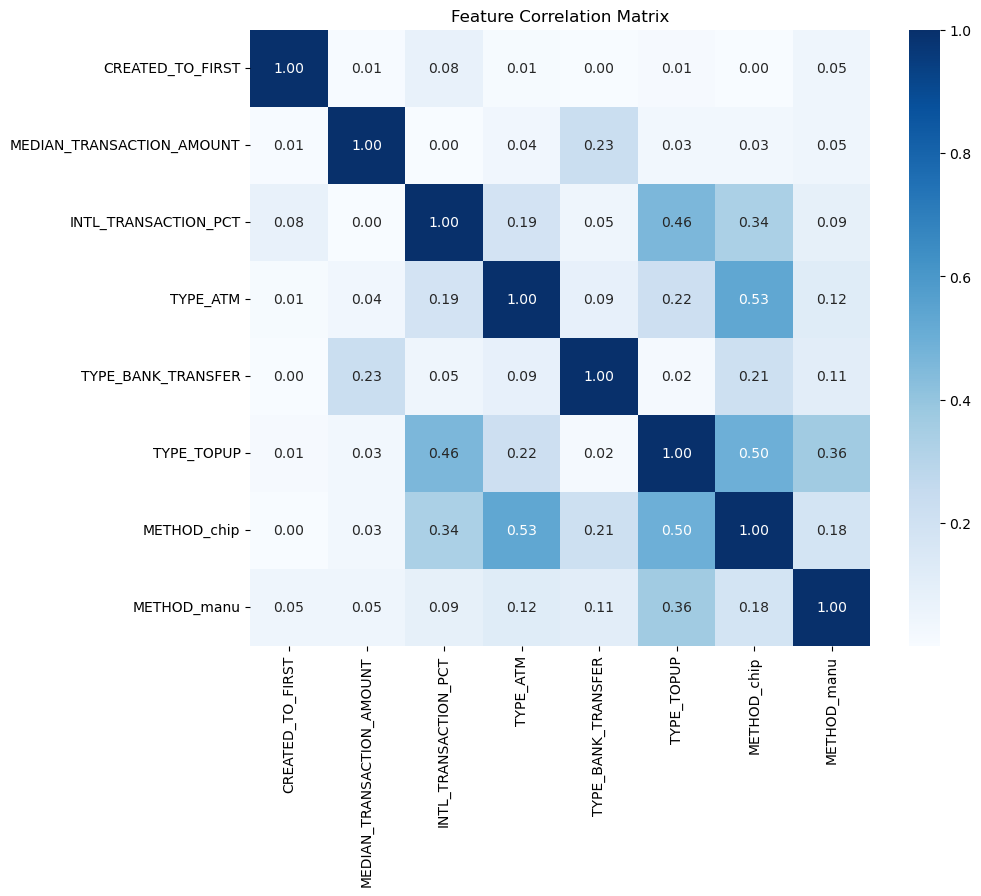

In [24]:
# establish correlation matrix for intercorrelation
corr_matrix = X.corr().abs() # absolute values to make visualizing easier

# visualize a simple correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

In [25]:
# review correlation between target and features
df[selected_features + [target]].corr()[target].sort_values().round(2)

INTL_TRANSACTION_PCT        -0.09
METHOD_chip                 -0.01
CREATED_TO_FIRST            -0.01
TYPE_TOPUP                   0.00
METHOD_manu                  0.05
MEDIAN_TRANSACTION_AMOUNT    0.11
TYPE_ATM                     0.16
TYPE_BANK_TRANSFER           0.17
IS_FRAUDSTER                 1.00
Name: IS_FRAUDSTER, dtype: float64

There are a few variables that appear to have intercorrelations:
* The groupings of TYPE and METHOD of transaction: Since TYPE provides more specificity, and has higher correlations with the target, we'll maintain that for the analysis. 
* KYC_PASSED and KYC_NONE: We didn't drop the first dummy for KYC, to figure out which would be most useful. Since KYC_NONE has the stronger relationship with our target, we're going to remove KYC_PASSED. 
* PHONE_COUNTRY_MATCH and PHONE_MULTIPLE_COUNTRIES: These strongly correlate with each other, and also have decent correlations with the target. However, PHONE_MULTIPLE_COUNTRIES has a slightly stronger correlation, so we'll keep that variable. 

In [26]:
# update features to remove multicollinear features
selected_features = [feature for feature in 
                     selected_features if feature not in 
                     ['METHOD_chip', 'METHOD_cont', 'METHOD_mags', 
                      'METHOD_manu', 'METHOD_mcon', 'METHOD_misc',
                      'KYC_PASSED', 'PHONE_COUNTRY_MATCH']]

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], 
                                                    y, test_size=0.4, 
                                                    random_state=17)

In [28]:
# determine hyperparameters
param_grid = {
    'max_depth': list(range(5,20)),
    'min_samples_leaf': [10],
    'max_features': list(range(2,10))
    }
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=17),
                          param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train, y_train)
print('Score: ', gridSearch.best_score_)

best_params = gridSearch.best_params_
print('Parameters: ', best_params)

Score:  0.9601027549179599
Parameters:  {'max_depth': 7, 'max_features': 4, 'min_samples_leaf': 10}


In [29]:
# train on tree model using best parameters
tree_model = DecisionTreeClassifier(random_state=17,
                                   max_depth=best_params['max_depth'],
                                   min_samples_leaf=best_params['min_samples_leaf'],
                                   max_features=best_params['max_features'])
tree_model.fit(X_train, y_train)

# get feature importances & list of features used
feature_importances = tree_model.feature_importances_

# generate a list of features used
features_used = X_train.columns[feature_importances > 0]  
list(features_used)

['CREATED_TO_FIRST',
 'MEDIAN_TRANSACTION_AMOUNT',
 'INTL_TRANSACTION_PCT',
 'TYPE_ATM',
 'TYPE_BANK_TRANSFER',
 'TYPE_TOPUP']

In [30]:
# isolate top features
selected_features = [feature for feature in 
                     all_features if feature in 
                     list(features_used)]

# reset X with top features
X = df[selected_features]

# resplit the data
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], 
                                                    y, test_size=0.4, 
                                                    random_state=17)

# scale the data
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# show distribution
print('Training samples:',len(X_train),'\n', 
      y_train.value_counts())
print('\n')
print('Testing samples:',len(X_test),'\n', 
      y_test.value_counts())

Training samples: 4311 
 IS_FRAUDSTER
0    4128
1     183
Name: count, dtype: int64


Testing samples: 2875 
 IS_FRAUDSTER
0    2761
1     114
Name: count, dtype: int64


## Modeling

When doing the modeling, I began with Random Forest Regression, Logistic Regression, the Decision Tree Classifier, a KNN classifier, and a stacked ensemble combining a few of these together. Each model worked fairly well, however the best performer was the KNN classifier. The stacked ensemble performed similarily well, however it didn't improve on teh KNN classifier so to minimize computational efforts I decided to limit modeling to KNN classification. 

This is all assuming that we want to focus on precision to minimize false positives in our target, for the best customer experience. 

In [31]:
# Define the parameter grid to search
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  
    'weights': ['uniform', 'distance'],  
    'leaf_size': [10, 30, 50]
}

# Initialize the k-NN classifier
knn_classifier = KNeighborsClassifier()

# Initialize GridSearchCV with k-NN classifier and parameter grid
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, 
                           scoring='accuracy')

# Perform GridSearchCV to find the best combination of hyperparameters
grid_search.fit(X_train, y_train)

# Get the best k-NN classifier model
best_knn_classifier = grid_search.best_estimator_

# Use the best model to make predictions
train_predictions = best_knn_classifier.predict(X_train)
test_predictions = best_knn_classifier.predict(X_test)

# Accuracy scores
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)
train_precision = round(precision_score(y_train, train_predictions), 3)
test_precision = round(precision_score(y_test, test_predictions), 3)

print('Training Scores:')
print('  Accuracy: %.3f' % train_accuracy)
print('  Precision: %.3f' % train_precision)
print('\nTesting Scores:')
print('  Accuracy: %.3f' % test_accuracy)
print('  Precision: %.3f' % test_precision)

Training Scores:
  Accuracy: 0.961
  Precision: 0.750

Testing Scores:
  Accuracy: 0.962
  Precision: 0.619


I want to also compare this to the null model as that will determine the overall benefit of this model. 

In [32]:
# compare to null model
target_mean = y.mean()
max_target_mean = np.max([y.mean(), 1-y.mean()]) # establish accuracy of null model
print('Proportion of 0\'s (Not Fraud Acct): %.3f' % (1-target_mean))
print('Proportion of 1\'s (Fraud Acct): %.3f' % target_mean)
print('Null model accuracy: %.3f' % max_target_mean)
print('Null model precision: %.3f' % target_mean)

Proportion of 0's (Not Fraud Acct): 0.959
Proportion of 1's (Fraud Acct): 0.041
Null model accuracy: 0.959
Null model precision: 0.041


## Conclusion

While the overall accuracy of the null model is comporable to that of the KNN Classifier, the KNN Classifier has much better precision. This would ensure we reduce the occurance of false positives, thereby supporting the customer experience. However, there is a noted disadvantage to using this classifier as it is not as transparent in decision making as, say, a decision tree classifier would be. As such, while it would be beneficial for implementation, it may not support business needs if there's a desire to develop a better understanding of the factors that help us identify fraudulent accounts. 